In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 150)

In [15]:
path1 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_identity.csv'
path2 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_transaction.csv'
path3 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_identity.csv'
path4 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_transaction.csv'

id = pd.read_csv(path1)
tranz = pd.read_csv(path2)
id_test = pd.read_csv(path3)
tranz_test = pd.read_csv(path4)

In [16]:
id_test.columns = [col.replace('-', '_') for col in id_test.columns]

In [17]:
tranz = tranz.merge(id, how='left', on='TransactionID')
tranz_test = tranz_test.merge(id_test, how = 'left', on = 'TransactionID')

In [18]:
tranz_test['isFraud'] = np.nan

In [19]:
transaction_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/Transaction_features.txt', header=None)[0].tolist()
id_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/id_features.txt', header=None)[0].tolist()

features_to_keep = set(transaction_features + id_features)
features_to_keep = [col for col in tranz.columns if col in features_to_keep]

tranz = tranz[features_to_keep]
tranz_test = tranz_test[features_to_keep]

In [20]:
#Find the number of missing values in each column
miss_val_tranz = tranz.isnull().sum()

#Turn the missing value counts into percentages
miss_val_per_tranz = (miss_val_tranz/ len(tranz))*100

#Return counts and percentages of missing values in each column
miss_data_tranz = pd.DataFrame({'MIssing Values': miss_val_tranz,'Percentage (%)':miss_val_per_tranz})

print('Columnswith 80 percent of non nan data:')



print(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist())
print('Number of such columns = ',len(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()))

Columnswith 80 percent of non nan data:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V6', 'V10', 'V12', 'V14', 'V19', 'V20', 'V23', 'V25', 'V26', 'V35', 'V37', 'V38', 'V39', 'V44', 'V45', 'V46', 'V53', 'V55', 'V56', 'V61', 'V62', 'V65', 'V66', 'V67', 'V70', 'V72', 'V75', 'V77', 'V81', 'V82', 'V83', 'V86', 'V87', 'V88', 'V89', 'V91', 'V94', 'V95', 'V98', 'V99', 'V107', 'V108', 'V109', 'V115', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V125', 'V130', 'V135', 'V172', 'V173', 'V188', 'V223', 'V242', 'V258', 'V261', 'V279', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V288', 'V289', 'V290', 'V294', 'V300', 'V304', 'V305', 'V308', 'V3

In [21]:
tranz = tranz[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]
tranz_test= tranz_test[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]

In [22]:
"""
Add useful features and factorize categorical features
"""

tranz["TransactionDay"] = np.floor(tranz["TransactionDT"] / (24*60*60))

for i in range(1,10):
    tranz["M"+str(i)] = tranz["M"+str(i)].astype(bool)

tranz_test["TransactionDay"] = np.floor(tranz_test["TransactionDT"] / (24*60*60))

#for i in range(1,10):
#    tranz_test["M"+str(i)] = tranz_test["M"+str(i)].astype(bool)    



In [23]:
#categorical_vars = ["ProductCD","card4","card6","P_emaildomain", "R_emaildomain"]

#for cat in categorical_vars:
    #tranz[cat] = pd.factorize(tranz[cat])[0]   
    #tranz_test[cat] = pd.factorize(tranz_test[cat])[0]  

In [24]:
"""
add universal id to dataset
"""
tranz["D1n"] = tranz["TransactionDay"] - tranz["D1"]
tranz['uid'] = tranz["card1"].astype(str) + '_' + tranz["addr1"].astype(str) + '_' + tranz["D1n"].astype(str)

tranz_test["D1n"] = tranz_test["TransactionDay"] - tranz_test["D1"]
tranz_test['uid'] = tranz_test["card1"].astype(str) + '_' + tranz_test["addr1"].astype(str) + '_' + tranz_test["D1n"].astype(str)

In [25]:
# Step 1: Sort the DataFrame by time so we can check recent transactions efficiently
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)

# Step 2: Create a unique key based on the three columns
tranz['key'] = (
    tranz['TransactionAmt'].astype(str) + '_' +
    tranz['ProductCD'].astype(str) + '_' +
    tranz['card1'].astype(str)
)
tranz_test['key'] = (
    tranz_test['TransactionAmt'].astype(str) + '_' +
    tranz_test['ProductCD'].astype(str) + '_' +
    tranz_test['card1'].astype(str)
)

# Create a boolean column 'key_match' indicating if the same key appears within 50 rows above or below
def add_key_match(df):
    key_arr = df['key'].values
    match = np.zeros(len(df), dtype=bool)
    for i in range(len(df)):
        start = max(0, i - 50)
        end = min(len(df), i + 51)
        window = np.r_[key_arr[start:i], key_arr[i+1:end]]
        if key_arr[i] in window:
            match[i] = True
    df['key_match'] = match

add_key_match(tranz)
add_key_match(tranz_test)

#tranz = tranz.drop('key',axis =1)
#tranz_test = tranz_test.drop('key',axis =1)


In [26]:
"""
Determines how many transactions of the same amount occur in plus/minus 500 seconds around a given transaction
for both tranz and tranz_test
"""

# For tranz
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz['IsDuplicateInWindowz'] = 1

tds = np.asarray(tranz['TransactionDT'].values)
keys = np.asarray(tranz['key'].values)

for i in range(len(tranz)):
    lower = tds[i] - 500
    upper = tds[i] + 500
    start = np.searchsorted(tds, lower, side='left')
    end = np.searchsorted(tds, upper, side='right')
    window_keys = keys[start:end]
    match_count = np.sum(window_keys == keys[i])
    tranz.at[i, 'IsDuplicateInWindowz'] = match_count

# For tranz_test
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)
tranz_test['IsDuplicateInWindowz'] = 1

tds_test = np.asarray(tranz_test['TransactionDT'].values)
keys_test = np.asarray(tranz_test['key'].values)

for i in range(len(tranz_test)):
    lower = tds_test[i] - 500
    upper = tds_test[i] + 500
    start = np.searchsorted(tds_test, lower, side='left')
    end = np.searchsorted(tds_test, upper, side='right')
    window_keys = keys_test[start:end]
    match_count = np.sum(window_keys == keys_test[i])
    tranz_test.at[i, 'IsDuplicateInWindowz'] = match_count

In [27]:
tranz[tranz['isFraud'] == 1].head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V6,V10,V12,V14,V19,V20,V23,V25,V26,V35,V37,V38,V39,V44,V45,V46,V53,V55,V56,V61,V62,V65,V66,V67,V70,V72,...,V87,V88,V89,V91,V94,V95,V98,V99,V107,V108,V109,V115,V117,V118,V120,V121,V123,V124,V125,V130,V135,V172,V173,V188,V223,V242,V258,V261,V279,V281,V282,V283,V284,V285,V286,V288,V289,V290,V294,V300,V304,V305,V308,V309,V310,V313,V314,V319,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDay,D1n,uid,key,key_match,IsDuplicateInWindowz
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,87.0,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,80.0,NaN,374.0,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-56.0,18268_251.0_-56.0,445.0_W_18268,False,1
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,169947.0,3.0,0.0,100.000000,NotFound,NaN,Found,Found,225.0,266.0,325.0,Found,Found,chrome 54.0 for android,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.0,1.0,13413_nan_1.0,37.098_C_13413,True,3
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,222455.0,0.0,0.0,100.000000,NotFound,43.0,Found,Found,225.0,266.0,325.0,Found,Found,chrome 54.0 for android,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.0,1.0,13413_nan_1.0,37.098_C_13413,True,3
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,3.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,271870.0,3.0,0.0,100.000000,NotFound,43.0,Found,Found,225.0,266.0,325.0,Found,Found,chrome 54.0 for android,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.0,1.0,13413_nan_1.0,37.098_C_13413,True,3
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,NaN,NaN,outlook.com,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0

In [28]:
#NORMALIZE D COLUMNS
for i in range(1,16):
    #if i in [1,2,3,5,9]: continue
    if i in [6,7,8,9,12,13,14]: continue
    tranz['D'+str(i)] =  tranz['D'+str(i)] - tranz.TransactionDT/(24*60*60) 
    tranz_test['D'+str(i)] =  tranz_test['D'+str(i)] - tranz_test.TransactionDT/(24*60*60) 

In [29]:
def encode_AG(groupby: str, aggregate_cols: list):
    global tranz, tranz_test
    # Only use numeric columns for aggregation
    numeric_cols = [col for col in aggregate_cols if pd.api.types.is_numeric_dtype(tranz[col])]
    # Compute the mean and std for train
    means = tranz.groupby(groupby)[numeric_cols].transform('mean').add_suffix('_uid_mean')
    stds = tranz.groupby(groupby)[numeric_cols].transform('std').add_suffix('_uid_std')
    tranz = pd.concat([tranz, means, stds], axis=1)

    # Compute the mean and std for test using train group statistics
    group_means = tranz.groupby(groupby)[numeric_cols].mean()
    group_stds = tranz.groupby(groupby)[numeric_cols].std()
    for col in numeric_cols:
        tranz_test[f"{col}_uid_mean"] = tranz_test[groupby].map(group_means[col])
        tranz_test[f"{col}_uid_std"] = tranz_test[groupby].map(group_stds[col])

# aggregate and frequency encoding features
columns_to_encode = []
columns_to_encode += ["TransactionAmt", "TransactionDT", "addr1", "card1", "card2", "card3"]

d_columns = [d for d in tranz.columns if d.startswith("D")] #and len(d) < 4]
#v_columns = [v for v in tranz.columns if v.startswith("V")] #and len(v) < 4]

columns_to_encode += d_columns
#columns_to_encode += v_columns

encode_AG('uid', columns_to_encode)

In [30]:
def encode_FE(cols: list, inplace=False):
    """
    input:
    cols: list of features to frequency encode
    inplace: replace the columns with their frequency encoding. 
    output:
    dataframe with frequency encoded features
    """
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        if inplace:
            col_name = col
        else:
            col_name = col + "_FE"
        # Combine both train and test for frequency calculation
        freq = pd.concat([tranz[col], tranz_test[col]]).value_counts(normalize=True)
        tranz[col_name] = tranz[col].map(freq)
        tranz_test[col_name] = tranz_test[col].map(freq)

columns_to_encode = ["addr1", "card1", "card2", "card3", "P_emaildomain", "R_emaildomain",'uid']
encode_FE(columns_to_encode)

In [31]:
tranz['TransactionDTz'] = pd.to_datetime(tranz['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))
tranz_test['TransactionDTz'] = pd.to_datetime(tranz_test['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))

tranz['Day'] = tranz['TransactionDTz'].dt.day
tranz_test['Day'] = tranz_test['TransactionDTz'].dt.day

tranz['Hour'] = tranz['TransactionDTz'].dt.hour
tranz_test['Hour'] = tranz_test['TransactionDTz'].dt.hour

del tranz['TransactionDTz']
del tranz_test['TransactionDTz'] 



In [32]:
tranz['TransactionAmt_third_decimal'] = tranz['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')
tranz_test['TransactionAmt_third_decimal'] = tranz_test['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')

In [33]:
'''
#NORMALIZE D COLUMNS
for i in range(1,16):
    #if i in [1,2,3,5,9]: continue
    if i in [6,7,8,9,12,13,14]: continue
    tranz['D'+str(i)] =  tranz['D'+str(i)] - tranz.TransactionDT/(24*60*60) 
    tranz_test['D'+str(i)] =  tranz_test['D'+str(i)] - tranz_test.TransactionDT/(24*60*60) 
'''

"\n#NORMALIZE D COLUMNS\nfor i in range(1,16):\n    #if i in [1,2,3,5,9]: continue\n    if i in [6,7,8,9,12,13,14]: continue\n    tranz['D'+str(i)] =  tranz['D'+str(i)] - tranz.TransactionDT/(24*60*60) \n    tranz_test['D'+str(i)] =  tranz_test['D'+str(i)] - tranz_test.TransactionDT/(24*60*60) \n"

In [34]:
tranz = tranz.fillna(-999)
tranz_test = tranz_test.fillna(-999)

In [35]:

for col in tranz.select_dtypes(include=['object','bool']).columns:
    tranz[col], _ = pd.factorize(tranz[col])

for col in tranz_test.select_dtypes(include=['object','bool']).columns:
    tranz_test[col], _ = pd.factorize(tranz_test[col])


In [36]:
print("Number of unique uid in tranz:", tranz['uid'].nunique())
print("Number of unique uid in tranz_test:", tranz_test['uid'].nunique())

Number of unique uid in tranz: 217850
Number of unique uid in tranz_test: 196187


In [37]:
common_uids = set(tranz['uid']).intersection(set(tranz_test['uid']))
print("Number of common uid in both tranz and tranz_test:", len(common_uids))

Number of common uid in both tranz and tranz_test: 196187


In [38]:
tranz = tranz.drop('TransactionDT',axis = 1)
tranz_test = tranz_test.drop('TransactionDT',axis = 1)

In [39]:
#y = tranz["isFraud"]
#X = tranz.drop(columns=["isFraud"])
#X = X.drop('TransactionDT', axis=1)

In [40]:
tranz

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V6,V10,V12,V14,V19,V20,V23,V25,V26,V35,V37,V38,V39,V44,V45,V46,V53,V55,V56,V61,V62,V65,V66,V67,V70,V72,V75,...,V304,V305,V308,V309,V310,V313,V314,V319,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDay,D1n,uid,key,key_match,IsDuplicateInWindowz,TransactionAmt_uid_mean,TransactionDT_uid_mean,addr1_uid_mean,card1_uid_mean,card2_uid_mean,card3_uid_mean,D1_uid_mean,D2_uid_mean,D3_uid_mean,D4_uid_mean,D5_uid_mean,D10_uid_mean,D11_uid_mean,D15_uid_mean,D1n_uid_mean,TransactionAmt_uid_std,TransactionDT_uid_std,addr1_uid_std,card1_uid_std,card2_uid_std,card3_uid_std,D1_uid_std,D2_uid_std,D3_uid_std,D4_uid_std,D5_uid_std,D10_uid_std,D11_uid_std,D15_uid_std,D1n_uid_std,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,R_emaildomain_FE,uid_FE,Day,Hour,TransactionAmt_third_decimal
0,2987000,0,68.50,0,13926,-999.0,150.0,0,142.0,0,315.0,87.0,19.0,0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,13.000000,-999.000000,12.000000,-999.000000,-999.000000,12.000000,12.000000,-1.000000,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,-13.0,0,0,0,1,68.500000,8.640000e+04,315.0,13926.0,-999.0,150.0,13.000000,-999.000000,12.000000,-999.000000,-999.000000,12.000000,12.000000,-1.000000,-13.0,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,0.044554,0.000051,-999.000000,0.875699,-999.000000,-999.0,9.113851e-07,2,0,0
1,2987001,0,29.00,0,2755,404.0,150.0,1,102.0,0,325.0,87.0,-999.0,1,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.000012,-999.000000,-999.000000,-1.000012,-999.000000,-1.000012,-999.000000,-1.000012,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,-999.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,1.0,1,1,0,1,29.000000,8.640100e+04,325.0,2755.0,404.0,150.0,-1.000012,-999.000000,-999.000000,-1.000012,-999.000000,-1.000012,-999.000000,-1.000012,1.0,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,0.079616,0.001219,0.005180,0.875699,0.466807,-999.0,9.113851e-07,2,0,0
2,2987002,0,59.00,0,4663,490.0,150.0,2,166.0,1,330.0,87.0,287.0,2,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,-1.000799,-999.000000,-999.000000,-1.000799,-999.000000,-1.000799,313.999201,313.999201,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,1.0,2,2,0,1,73.500000,8.565982e+06,330.0,4663.0,490.0,150.0,-1.393310,-1.524147,-80.190814,-0.893310,-75.524147,-0.893310,314.106690,314.106690,1.0,17.058722,6.189580e+06,0.0,0.0,0.0,0.0,0.449721,0.447954,68.918694,0.197544,66.040214,0.197544,0.197544,0.197544,0.0,0.050094,0.001635,0.065296,0.875699,0.010641,-999.0,3.645540e-06,2,0,0
3,2987003,0,50.00,0,18132,567.0,150.0,1,117.0,1,476.0,87.0,-999.0,3,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,110.998854,110.998854,-1.001146,92.998854,-1.001146,82.998854,-999.000000,109.998854,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-99

In [41]:
from sklearn.model_selection import train_test_split

y = tranz["isFraud"]
X = tranz.drop(columns=["isFraud","card1", "addr1", "D1",  "D1n",'key', "TransactionID",'uid'])  #"uid"


# Split without shuffling, preserving the order (forward in TransactionDT)
#split_idx = int(0.8 * len(X))
#X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
#y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
X

,TransactionAmt,ProductCD,card2,card3,card4,card5,card6,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V6,V10,V12,V14,V19,V20,V23,V25,V26,V35,V37,V38,V39,V44,V45,V46,V53,V55,V56,V61,V62,V65,V66,V67,V70,V72,V75,V77,V81,V82,V83,V86,...,V290,V294,V300,V304,V305,V308,V309,V310,V313,V314,V319,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDay,key_match,IsDuplicateInWindowz,TransactionAmt_uid_mean,TransactionDT_uid_mean,addr1_uid_mean,card1_uid_mean,card2_uid_mean,card3_uid_mean,D1_uid_mean,D2_uid_mean,D3_uid_mean,D4_uid_mean,D5_uid_mean,D10_uid_mean,D11_uid_mean,D15_uid_mean,D1n_uid_mean,TransactionAmt_uid_std,TransactionDT_uid_std,addr1_uid_std,card1_uid_std,card2_uid_std,card3_uid_std,D1_uid_std,D2_uid_std,D3_uid_std,D4_uid_std,D5_uid_std,D10_uid_std,D11_uid_std,D15_uid_std,D1n_uid_std,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,R_emaildomain_FE,uid_FE,Day,Hour,TransactionAmt_third_decimal
0,68.50,0,-999.0,150.0,0,142.0,0,87.0,19.0,0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,-999.000000,12.000000,-999.000000,-999.000000,12.000000,12.000000,-1.000000,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,0,1,68.500000,8.640000e+04,315.0,13926.0,-999.0,150.0,13.000000,-999.000000,12.000000,-999.000000,-999.000000,12.000000,12.000000,-1.000000,-13.0,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,0.044554,0.000051,-999.000000,0.875699,-999.000000,-999.0,9.113851e-07,2,0,0
1,29.00,0,404.0,150.0,1,102.0,0,87.0,-999.0,1,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-999.000000,-999.000000,-1.000012,-999.000000,-1.000012,-999.000000,-1.000012,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,-999.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,0,1,29.000000,8.640100e+04,325.0,2755.0,404.0,150.0,-1.000012,-999.000000,-999.000000,-1.000012,-999.000000,-1.000012,-999.000000,-1.000012,1.0,-999.000000,-9.990000e+02,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,0.079616,0.001219,0.005180,0.875699,0.466807,-999.0,9.113851e-07,2,0,0
2,59.00,0,490.0,150.0,2,166.0,1,87.0,287.0,2,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,-999.000000,-999.000000,-1.000799,-999.000000,-1.000799,313.999201,313.999201,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,1.0,0,1,73.500000,8.565982e+06,330.0,4663.0,490.0,150.0,-1.393310,-1.524147,-80.190814,-0.893310,-75.524147,-0.893310,314.106690,314.106690,1.0,17.058722,6.189580e+06,0.0,0.0,0.0,0.0,0.449721,0.447954,68.918694,0.197544,66.040214,0.197544,0.197544,0.197544,0.0,0.050094,0.001635,0.065296,0.875699,0.010641,-999.0,3.645540e-06,2,0,0
3,50.00,0,567.0,150.0,1,117.0,1,87.0,-999.0,3,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,110.998854,-1.001146,92.998854,-1.001146,82.998854,-999.000000,109.998854,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,

In [43]:
#idxT = X.index[:3*len(X)//4]
#idxV = X.index[3*len(X)//4:]
cols = X.columns.to_list()

In [44]:
print("XGBoost version:", xgb.__version__)

clf = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric= 'aucpr',
    # USE CPU
    nthread=4,
    tree_method='hist',  # Use CPU since GPU is not available
    # USE GPU
    #tree_method='gpu_hist' 
    early_stopping_rounds=10
)
h = clf.fit(X_train, y_train, 
    eval_set=[(X_test,y_test)],
    verbose=50)

XGBoost version: 3.0.2
[0]	validation_0-aucpr:0.45528
[50]	validation_0-aucpr:0.71940
[100]	validation_0-aucpr:0.76825
[150]	validation_0-aucpr:0.80560
[200]	validation_0-aucpr:0.82921
[250]	validation_0-aucpr:0.84503
[300]	validation_0-aucpr:0.85645
[350]	validation_0-aucpr:0.86562
[400]	validation_0-aucpr:0.87290
[450]	validation_0-aucpr:0.87815
[500]	validation_0-aucpr:0.88360
[550]	validation_0-aucpr:0.88808
[600]	validation_0-aucpr:0.89117
[650]	validation_0-aucpr:0.89459
[700]	validation_0-aucpr:0.89705
[750]	validation_0-aucpr:0.89964
[800]	validation_0-aucpr:0.90190
[850]	validation_0-aucpr:0.90386
[900]	validation_0-aucpr:0.90541
[950]	validation_0-aucpr:0.90688
[1000]	validation_0-aucpr:0.90807
[1050]	validation_0-aucpr:0.90940
[1100]	validation_0-aucpr:0.91055
[1150]	validation_0-aucpr:0.91169
[1200]	validation_0-aucpr:0.91246
[1250]	validation_0-aucpr:0.91334
[1300]	validation_0-aucpr:0.91401
[1350]	validation_0-aucpr:0.91468
[1400]	validation_0-aucpr:0.91530
[1450]	validat

In [45]:
from sklearn.metrics import average_precision_score

# Predict probabilities for the validation set
y_probs = clf.predict_proba(X_test)[:, 1]

# Calculate AUPRC
auprc = average_precision_score(y_test, y_probs)
print("AUPRC:", auprc)

AUPRC: 0.9191396791176926


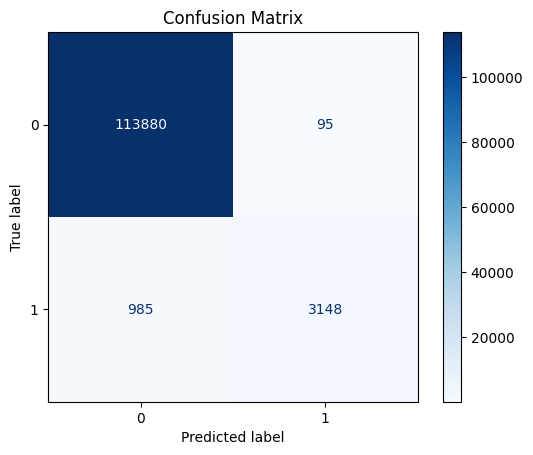

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for the validation set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

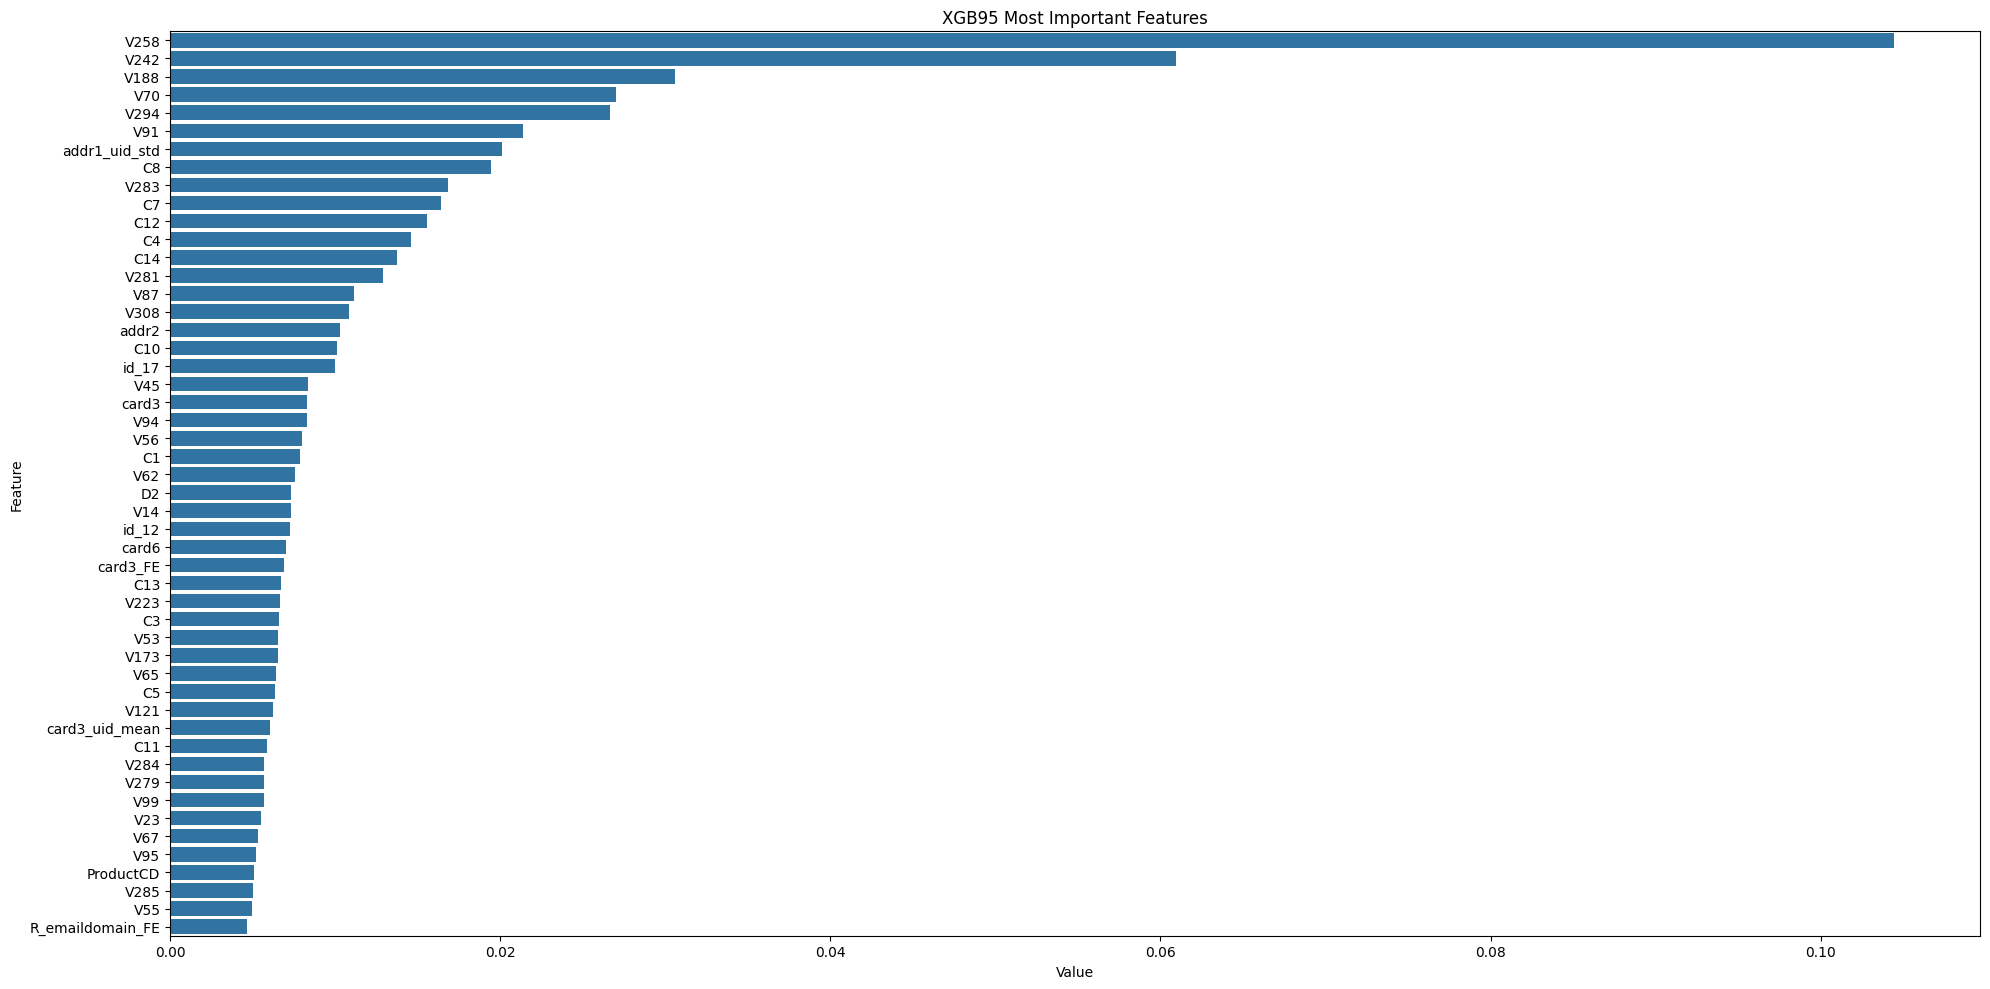

In [47]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [48]:
feature_imp.sort_values(by="Value", ascending=False).iloc[:50]

,Value,Feature
186,0.104431,V258
185,0.060953,V242
184,0.030586,V188
183,0.026989,V70
182,0.026670,V294
181,0.021348,V91
180,0.020098,addr1_uid_std
179,0.019435,C8
178,0.016831,V283
177,0.016421,C7


In [49]:
X_train

,TransactionAmt,ProductCD,card2,card3,card4,card5,card6,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V6,V10,V12,V14,V19,V20,V23,V25,V26,V35,V37,V38,V39,V44,V45,V46,V53,V55,V56,V61,V62,V65,V66,V67,V70,V72,V75,V77,V81,V82,V83,V86,...,V290,V294,V300,V304,V305,V308,V309,V310,V313,V314,V319,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDay,key_match,IsDuplicateInWindowz,TransactionAmt_uid_mean,TransactionDT_uid_mean,addr1_uid_mean,card1_uid_mean,card2_uid_mean,card3_uid_mean,D1_uid_mean,D2_uid_mean,D3_uid_mean,D4_uid_mean,D5_uid_mean,D10_uid_mean,D11_uid_mean,D15_uid_mean,D1n_uid_mean,TransactionAmt_uid_std,TransactionDT_uid_std,addr1_uid_std,card1_uid_std,card2_uid_std,card3_uid_std,D1_uid_std,D2_uid_std,D3_uid_std,D4_uid_std,D5_uid_std,D10_uid_std,D11_uid_std,D15_uid_std,D1n_uid_std,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,R_emaildomain_FE,uid_FE,Day,Hour,TransactionAmt_third_decimal
40809,100.000,4,399.0,150.0,3,150.0,0,87.0,-999.0,5,4,1.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,1.0,597.327650,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,58410.0,0.0,0.0,100.000000,1,52.0,2,2,166.0,300.0,214.0,2,2,22,1,1,1,1,2,19,11.0,0,1,100.000000,2.055880e+06,264.0,6177.0,399.0,150.0,597.205087,597.205087,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-598.0,0.000000,1.481232e+06,0.0,0.0,0.0,0.0,0.173331,0.173331,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.0,0.075141,0.000020,0.012465,0.875699,0.076117,0.145131,1.822770e-06,12,16,0
285886,29.990,0,345.0,150.0,1,224.0,1,87.0,4.0,1,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-999.000000,-999.000000,-81.113565,-999.000000,-81.113565,-81.113565,-81.113565,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.000000,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,81.0,1,2,29.990000,7.008356e+06,143.0,7900.0,345.0,150.0,-81.115237,-999.000000,-81.116910,-81.115237,-81.116910,-81.115237,-81.115237,-81.115237,81.0,0.000000,2.043539e+02,0.0,0.0,0.0,0.0,0.002365,-999.000000,-999.000000,0.002365,-999.000000,0.002365,0.002365,0.002365,0.0,0.019081,0.000464,0.000635,0.875699,0.466807,-999.000000,2.734155e-06,22,2,0
104256,107.950,0,111.0,150.0,2,226.0,0,87.0,-999.0,10,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,1.0,477.024051,-5.975949,478.024051,-5.975949,478.024051,-999.000000,478.024051,0,0,0,0,0,0,0,0,0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,200.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.000000,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,23.0,0,1,156.204167,6.024287e+06,191.0,11690.0,111.0,150.0,477.441127,477.441127,-56.642207,478.107793,-56.642207,478.107793,431.660861,478.107793,-478.0,71.724617,3.637136e+06,0.0,0.0,0.0,0.0,0.362243,0.362243,43.036818,0.184962,43.036818,0.184962,154.163989,0.184962,0.0,0.028895,0.000548,0.076448,0.875699,0.015504,-999.000000,1.093662e-05,24,23,0
507860,241.950,0,327.0,150.0,0,102.0,0,87.0,3.0,0,0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,23.067685,-67.932315,-999.000000,-999.000000,23.067685,23.067685,23.067685,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-999.0,-999.0,-999.0,-999

In [50]:
'''
# Save the original index to restore order later
tranz_test['orig_index'] = tranz_test.index

# Shuffle the rows randomly
tranz_test_shuffled = tranz_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Predict probabilities for the shuffled test set
tranz_test_shuffled_probs = clf.predict_proba(tranz_test_shuffled[X_train.columns])[:, 1]

# Assign the predicted probabilities to the shuffled DataFrame
tranz_test_shuffled['isFraud'] = tranz_test_shuffled_probs

# Restore the original order using 'orig_index'
tranz_test_shuffled_sorted = tranz_test_shuffled.sort_values('orig_index').reset_index(drop=True)

# Update the 'isFraud' column in tranz_test with the predicted probabilities in original order
tranz_test['isFraud'] = tranz_test_shuffled_sorted['isFraud'].values

# Drop the helper column
tranz_test.drop(columns=['orig_index'], inplace=True)
'''

"\n# Save the original index to restore order later\ntranz_test['orig_index'] = tranz_test.index\n\n# Shuffle the rows randomly\ntranz_test_shuffled = tranz_test.sample(frac=1, random_state=42).reset_index(drop=True)\n\n# Predict probabilities for the shuffled test set\ntranz_test_shuffled_probs = clf.predict_proba(tranz_test_shuffled[X_train.columns])[:, 1]\n\n# Assign the predicted probabilities to the shuffled DataFrame\ntranz_test_shuffled['isFraud'] = tranz_test_shuffled_probs\n\n# Restore the original order using 'orig_index'\ntranz_test_shuffled_sorted = tranz_test_shuffled.sort_values('orig_index').reset_index(drop=True)\n\n# Update the 'isFraud' column in tranz_test with the predicted probabilities in original order\ntranz_test['isFraud'] = tranz_test_shuffled_sorted['isFraud'].values\n\n# Drop the helper column\ntranz_test.drop(columns=['orig_index'], inplace=True)\n"

In [51]:
'''
# Store original index separately (without adding a column)
orig_index = tranz_test.index.copy()

# Shuffle the DataFrame
tranz_test_shuffled = tranz_test.sample(frac=1, random_state=42)

# Predict probabilities
tranz_test_shuffled_probs = clf.predict_proba(tranz_test_shuffled[X_train.columns])[:, 1]

# Assign predictions to the shuffled DataFrame
tranz_test_shuffled = tranz_test_shuffled.copy()
tranz_test_shuffled['isFraud'] = tranz_test_shuffled_probs

# Restore original order using the stored index
tranz_test['isFraud'] = tranz_test_shuffled.loc[orig_index, 'isFraud'].values
'''

"\n# Store original index separately (without adding a column)\norig_index = tranz_test.index.copy()\n\n# Shuffle the DataFrame\ntranz_test_shuffled = tranz_test.sample(frac=1, random_state=42)\n\n# Predict probabilities\ntranz_test_shuffled_probs = clf.predict_proba(tranz_test_shuffled[X_train.columns])[:, 1]\n\n# Assign predictions to the shuffled DataFrame\ntranz_test_shuffled = tranz_test_shuffled.copy()\ntranz_test_shuffled['isFraud'] = tranz_test_shuffled_probs\n\n# Restore original order using the stored index\ntranz_test['isFraud'] = tranz_test_shuffled.loc[orig_index, 'isFraud'].values\n"

In [52]:
# Predict probabilities for the test set
tranz_test_probs = clf.predict_proba(tranz_test[X_train.columns])[:, 1]

# Fill the isFraud column with predicted probabilities
tranz_test['isFraud'] = tranz_test_probs

In [53]:
tranz_test

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V6,V10,V12,V14,V19,V20,V23,V25,V26,V35,V37,V38,V39,V44,V45,V46,V53,V55,V56,V61,V62,V65,V66,V67,V70,V72,V75,...,V304,V305,V308,V309,V310,V313,V314,V319,id_01,id_02,id_05,id_06,id_11,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDay,D1n,uid,key,key_match,IsDuplicateInWindowz,TransactionAmt_uid_mean,TransactionAmt_uid_std,TransactionDT_uid_mean,TransactionDT_uid_std,addr1_uid_mean,addr1_uid_std,card1_uid_mean,card1_uid_std,card2_uid_mean,card2_uid_std,card3_uid_mean,card3_uid_std,D1_uid_mean,D1_uid_std,D2_uid_mean,D2_uid_std,D3_uid_mean,D3_uid_std,D4_uid_mean,D4_uid_std,D5_uid_mean,D5_uid_std,D10_uid_mean,D10_uid_std,D11_uid_mean,D11_uid_std,D15_uid_mean,D15_uid_std,D1n_uid_mean,D1n_uid_std,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,R_emaildomain_FE,uid_FE,Day,Hour,TransactionAmt_third_decimal
0,3663549,0.000088,31.950,0,10409,111.0,150.0,0,226.0,0,170.0,87.0,1.0,0,0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,205.999722,205.999722,-186.000278,184.999722,-186.000278,204.999722,-10.000278,195.999722,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.000000,47.950001,0.000000,0.000000,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,213.0,-206.0,0,0,0,1,87.838889,54.584946,6.971272e+06,3.803137e+06,170.0,0.0,10409.0,0.0,111.0,0.0,150.0,0.0,205.369533,0.229023,205.369533,0.229023,-71.963801,43.816757,185.258421,0.159074,-61.741579,73.411121,205.258421,0.159074,-9.754432,0.180663,46.813977,137.592215,-206.0,0.0,0.003944,0.000137,0.076448,0.875699,0.466807,-999.000000,4.283510e-05,1,0,0
1,3663550,0.000049,49.000,0,4272,111.0,150.0,0,226.0,0,299.0,87.0,4.0,1,0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,-64.000729,-64.000729,-206.000729,420.999271,-206.000729,17.999271,420.999271,420.999271,0,1,0,1,0,0,1,1,1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,77.000000,0.000000,280.000000,0.000000,0.000000,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,213.0,64.0,1,1,0,1,94.000000,80.247534,9.820984e+06,4.043332e+06,299.0,0.0,4272.0,0.0,111.0,0.0,150.0,0.0,-64.525934,0.277429,-64.573723,0.270512,-102.740390,39.951114,420.902637,0.390770,-91.954506,60.594073,18.188352,0.249186,353.759610,164.373621,420.902637,0.390770,64.0,0.0,0.088046,0.001893,0.076448,0.875699,0.056060,-999.000000,3.189848e-05,1,0,0
2,3663551,0.004162,171.000,0,4476,574.0,150.0,0,226.0,0,472.0,87.0,2635.0,2,0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,-76.001273,-76.001273,-203.001273,-116.001273,-203.001273,-77.001273,-77.001273,-116.001273,0,0,0,1,1,0,2,2,2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.000000,0.000000,1058.000000,0.000000,0.000000,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,0,0,-999.0,-999.0,-999.0,0,0,0,0,0,0,0,0,0,213.0,76.0,2,2,0,1,160.722222,57.946025,1.125418e+07,2.114654e+06,472.0,0.0,4476.0,0.0,574.0,0.0,150.0,0.0,-76.701137,0.334852,-76.687298,0.339810,-128.334357,23.781438,-97.090026,27.657135,-122.491388,25.809819,-76.923359,0.134888,-82.653866,22.192849,-89.923359,18.860438,76.0,0.0,0.016258,0.000076,0.000121,0.875699,0.091742,-999.000000,1.731632e-05,1,0,0
3,3663552,0.000168,284.950,0,10989,360.0,150.0,0,166.0,0,205.0,87.0,17.0,0,0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,-171.001273,-171.001273,-172.001273,28.998727,-172.001273,28.998727,28.998727,28.998727,0,0,1,0,0,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.

In [54]:
tranz_test[['TransactionID', 'isFraud']].to_csv('sub.csv', index=False)

private = 89.7, public = 92.5